#QShadow Tomography  with RBM

In [ ]:
!pip install qiskit ipywidgets

In [ ]:
from qiskit import *
from numpy import pi
import numpy as np
import math

#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

#Generic class for qiskit circuit

In [ ]:
class qCirc():
  def __init__(self, _circ, _nqbits, _print = False):
    self.__nqbits = _nqbits
    self.__circ = _circ
    if (_print ):
      print(_circ)

  def _measure(self):
    for ind in range (0, self.__nqbits):
      self.__circ.measure(ind, ind)

  def get_datasource(self, nshots):
    backend_sim = Aer.get_backend('qasm_simulator')
    self._measure()
    job_sim = execute(self.__circ, backend_sim, shots = nshots, memory=True)
    result_sim = job_sim.result()
    data =  result_sim.get_memory()
  
    list_ = []
    for num in data:
      list_.append([int(numeric_string) for numeric_string in list(num)])
    return  tf.convert_to_tensor(list_,tf.float32)
    

#W State with 'n' qubits

In [ ]:
class qWn(qCirc):
  def __F_gate(self,circ,q,i,j,n,k) :
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    circ.ry(-theta,q[j])       
    circ.cz(q[i],q[j])
    circ.ry(theta,q[j])
    circ.barrier(q[i])
  def __init__(self, nqbits = 5, _print = False):
    qreg_q = QuantumRegister(nqbits, 'q')
    creg_c = ClassicalRegister(nqbits, 'c')
    circ = QuantumCircuit(qreg_q, creg_c)
    circ.x(qreg_q[nqbits-1]) 
    for i in range(nqbits):
      if (i+1 < nqbits):
        self.__F_gate(circ, qreg_q, nqbits-1-i, nqbits-2-i, nqbits, i+1)
    for i in range(nqbits):
      if (i+1 < nqbits):
        circ.cx(qreg_q[nqbits-2-i],qreg_q[nqbits-1-i])
    super().__init__(circ, nqbits, _print)

In [ ]:
# Test qWn
qw = qWn(4, True)
data_qw = qw.get_datasource(10)
print(data_qw)

       ┌──────────┐                                       ┌─────────┐          
q_0: ──┤ RY(-π/4) ├────────────────────────────────────■──┤ RY(π/4) ├───────■──
     ┌─┴──────────┴─┐                 ┌─────────────┐  │  └────░────┘     ┌─┴─┐
q_1: ┤ RY(-0.95532) ├───────────────■─┤ RY(0.95532) ├──■───────░───────■──┤ X ├
     └─┬──────────┬─┘   ┌─────────┐ │ └──────░──────┘          ░     ┌─┴─┐└───┘
q_2: ──┤ RY(-π/3) ├───■─┤ RY(π/3) ├─■────────░─────────■─────────────┤ X ├─────
       └──┬───┬───┘   │ └────░────┘          ░       ┌─┴─┐           └───┘     
q_3: ─────┤ X ├───────■──────░───────────────────────┤ X ├─────────────────────
          └───┘              ░                       └───┘                     
c: 4/══════════════════════════════════════════════════════════════════════════
                                                                               
tf.Tensor(
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0.

## RBM Class

In [ ]:
import random
class RBM:
  def __init__(self, visualUnits, hiddenUnits, alpha = 0.1 ):
    self.epoch_div = 10
    self.__hiddenUnits = hiddenUnits
    self.__visualUnits = visualUnits
    self.__alpha = alpha
    self.__reset_params()

  def __reset_params(self):
    self.__vb = tf.Variable(tf.zeros([self.__visualUnits]), tf.float32)                     # Visual Layer bias
    self.__hb = tf.Variable(tf.zeros([self.__hiddenUnits]), tf.float32)                     # Hidden Layer bias
    self.__W  = tf.Variable(tf.zeros([self.__visualUnits, self.__hiddenUnits]), tf.float32) # Weight matrix
  
  def set_params(self, vb, hb, w):
    self.__vb = vb
    self.__hb = hb
    self.__W =w

  def get_vb( self ):
    return self.__vb
  def get_hb( self ):
    return self.__hb
  def get_W( self ):
    return self.__W
 
  def make_hidden_layer(self, visual_state):
    hidden_proba = tf.nn.sigmoid(tf.matmul([visual_state], self.__W) + self.__hb)  # probabilities of the hidden units
    hidden_state = tf.nn.relu(tf.sign(hidden_proba - tf.random.uniform(tf.shape(hidden_proba)))) # sample_h_given_X
    return hidden_state[0]

  def remake_visual_layer(self, hidden_state_source ):
    visual_proba = tf.nn.sigmoid(tf.matmul([hidden_state_source], tf.transpose(self.__W)) + self.__vb) 
    visual_state = tf.nn.relu(tf.sign(visual_proba - tf.random.uniform(tf.shape(visual_proba)))) #sample_v_given_h
    return visual_state[0]
   
  def error(self,v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

  def train(self, data_set, epochs = 100, every_epochs = 50, every_step = 0, show = False):
    every_epochs = epochs / self.epoch_div
    self.__reset_params()
    by_epochs = []
    ind_epoch  = 0
    step = 0
    ind_step = 0
    for epoch in range(1, epochs + 1):
      ind_epoch += 1
      for item in data_set: # cada item es del tipo [1.,0.,0.]
        visual_0 = item
        hidden_0 = self.make_hidden_layer(visual_0)
        visual_1 = self.remake_visual_layer(hidden_0)
        hidden_1 = self.make_hidden_layer(visual_1)
        delta_W = tf.matmul(tf.transpose([visual_0]), [hidden_0]) - tf.matmul(tf.transpose([visual_1]), [hidden_1])
        # los valores de los elementos de delta_w pueden ser sólo -1, 0 , 1
        self.__W = self.__W + self.__alpha * delta_W
        self.__vb = self.__vb + self.__alpha * tf.reduce_mean(visual_0 - visual_1, 0)
        self.__hb = self.__hb + self.__alpha * tf.reduce_mean(hidden_0 - hidden_1, 0) 
        step += 1
        ind_step += 1
        if every_step > 0:
          if ind_step == every_step:
            ind_step = 0
            data = [0, step, self.__vb, self.__hb,self.__W]
            by_epochs.append(data)
            if show:
              print ("   >> training >> step = " + str(step))
      if (ind_epoch >= every_epochs and every_step == 0):
        ind_epoch = 0
        data = [epoch, step, self.__vb, self.__hb,self.__W]
        by_epochs.append(data)
        if show:
          print ("   >> training >> epoch = " + str(epoch))
    return by_epochs

  def get_sigma_tests( self, n , ntrips = 10):   # Gibbs Sampling
    list = []
    qbits_number = self.__visualUnits
  
    for index in range(n):
      random_list = [random.randint(0, 1) for _ in range(qbits_number)]
      visual_0 = tf.convert_to_tensor(random_list,tf.float32)

      for ii in range (ntrips):   
        hidden_0 = self.make_hidden_layer(visual_0)
        visual_1 = self.remake_visual_layer(hidden_0)
        visual_0 = visual_1
      
      list.append(visual_1.numpy().tolist())
    
    return list

  def check(self,data):
    nerr = 0
    count_err = 0
    for item in data:
      check_visual_0 = item
      check_hidden_0 = self.make_hidden_layer(check_visual_0)
      check_visual_1 = self.remake_visual_layer(check_hidden_0)
      err = tf.reduce_mean(tf.abs(check_visual_1 - check_visual_0), 0) 
      nerr = nerr + err
      if (err != 0):
        count_err += 1
        print(check_visual_0)
        print(check_visual_1)
        print('-------------------')
    nerr = nerr / len(data) 
    tf.print(nerr)
    print (str(count_err) + " errors of " + str(len(data)))

#Overlap

In [ ]:
class Overlap:

  # calculate overlap between `state wave function`(psi_w) and the `RBM wave function`
  def _calculate_overlap(self, sigmas_ok, sigmas_all, b, c, w, psi_w, print_prob = False):
    probability_distributions_ok = self._calculate_probability_distribution(sigmas_ok, b, c, w) #P_lambda(sigma)
    probability_distributions_all = self._calculate_probability_distribution(sigmas_all, b, c, w) #P_lambda(sigma)

    Z = self._sumList(probability_distributions_all) #Z
    if (print_prob):
      tf.print("> Overlap Class > Probability Distribution = " , probability_distributions_ok)
      tf.print("> Overlap Class > sum Z = ", Z)
      probnor = probability_distributions_ok / Z
      tf.print("> Overlap Class > Probability Distr. norm. = " , probnor)
    psi_lambda_results = []
    mult_results = []
    for p in probability_distributions_ok:
        psi_lamda = math.sqrt(p/Z) #RBM wave-function
        #mult_results.append(psi_w * psi_lamda)
        mult_results.append(psi_w * psi_lamda)
    o = self._sumList(mult_results)
    return o

  def _estimate_overlap(self, sigmas_ok, sigmas_test, b, c, w):
    print(' > Estimate Overlap > Prob. Distribution Sigmas OK ...')
    probability_distributions = self._calculate_probability_distribution(sigmas_ok, b, c, w) #P_lambda(sigma)
    
    sigmas_intersection = self._intersection(sigmas_test, sigmas_ok)
    print(' > Estimate Overlap > Prob. Distribution Sigmas Intersection ...')
    probability_distributions_intersection = self._calculate_probability_distribution(sigmas_intersection, b, c, w)
    sum1 = 0
    sum3 = 0
    N = len(sigmas_ok)
    n = len(sigmas_test)
    n_intersection = len(sigmas_intersection)

    print(' > Estimate Overlap >' ,'n', n, 'N', N, 'sigmas_intersection', len(sigmas_intersection))
    k = 1/math.sqrt(N)
  
    for pj in probability_distributions_intersection:
      sum1 = sum1 + ((1/math.sqrt(pj))*k)
    print(' > Estimate Overlap > Prob. Distribution sum3 ...')
    #1/√N   correcto??
    for pk in probability_distributions:
      sum3 = sum3 + math.sqrt(pk/N)
    print(' > Estimate Overlap > Done ________')
    return ((1/n)*sum1)*sum3  

  def _intersection(self, lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

  def _sumList(self, numList):
    result = 0
    for i in numList:
      result += i
    return result
    
  def _calculate_probability_distribution(self, sigmas, vb, hb, w):
    e = math.e
    n_visual_layer = len(vb)
    n_hidden_layer = len(hb)
    probabilities = [] #P_k(sigma)
    for sigma in sigmas: 
      sum_bsig = 0
      for v in range(n_visual_layer):
        sum_bsig += vb[v] * sigma[v]

      sum_log = 0
      for i in range(n_hidden_layer): 
        sum_wij = 0
        for j in range(n_visual_layer):
          sum_wij += w[j][i] * sigma[j]
        sum_log += math.log(1 + pow(e, hb[i] + sum_wij))

      probabilities.append(pow(e, sum_bsig + sum_log))

    return probabilities





#Generation of some sigmas (W state)

In [ ]:
class Sigmas:
  def get_sigmas_ok(self, size):
    final_list = []
    for i in range(size):
        array = [0] * size
        array[i] = 1
        final_list.append(array)
    return final_list
  def get_sigmas_all(self, size):
    initial_array = [0] * size
    final_list = self._generate_list(initial_array, [])
    return final_list
  def _generate_list(self, array, final_list):
    first = True
    while np.any(array) or first:
      first = False
      final_list.append(array)
      array = self._sum_1(array)
    return final_list
  def _sum_1(self, array):
    reversed_array = array[::-1]
    for i, num in list(enumerate(reversed_array)):
      if num == 0:
        reversed_array[i] = 1
        break
      else:
        reversed_array[i] = 0
    return reversed_array[::-1]

CT_Sigmas_Ok_20 = Sigmas().get_sigmas_ok( size = 20 )
CT_Sigmas_Ok_5 = Sigmas().get_sigmas_ok( size = 5 )
CT_Sigmas_All_5 = Sigmas().get_sigmas_all( size = 5 )
CT_Sigmas_Ok_6 = Sigmas().get_sigmas_ok( size = 6 )
CT_Sigmas_All_6 = Sigmas().get_sigmas_all( size = 6)
#CT_Sigmas_All_20 = Sigmas().get_sigmas_all( size = 20 )
#print(CT_Sigmas_All_5)

In [ ]:

class Overlap_Wn(Overlap):
  def __init__(self, nv, nh, generateAllSigmas = False):
    self.__nv = nv
    self.__nh = nh
    if nv == 20:
      self.__sigmas_ok = CT_Sigmas_Ok_20
      #self.__sigmas_all = CT_Sigmas_All_20
    elif nv == 5:
      self.__sigmas_ok = CT_Sigmas_Ok_5
      self.__sigmas_all = CT_Sigmas_All_5      
    elif nv == 6:
      self.__sigmas_ok = CT_Sigmas_Ok_6
      self.__sigmas_all = CT_Sigmas_All_6
    else:
      self.__sigmas_ok = self._get_sigmas_ok( nv )
    if generateAllSigmas:
      self.__sigmas_all = self._get_sigmas_all( nv )
    
    self.__psi_w = 1/math.sqrt(len(self.__sigmas_ok)) #w-state wave-function  número de qubits

  def calc_overlap(self, b , c , w, print_prob_distribution = False  ):
    return self._calculate_overlap(sigmas_ok = self.__sigmas_ok, sigmas_all = self.__sigmas_all, b = b, c = c, w = w, psi_w = self.__psi_w, print_prob =  print_prob_distribution)
  
  def est_overlap(self, b , c , w, n = 1000, t = 10 ):
    rbm = RBM( self.__nv, self.__nh , alpha = 0 )
    rbm.set_params( b, c, w)
    sigmas_test = rbm.get_sigma_tests(n, t)
    return self._estimate_overlap(sigmas_ok = self.__sigmas_ok, sigmas_test = sigmas_test, b = b, c = c, w = w)
   
  def _get_sigmas_all(self, size):
    initial_array = [0] * size
    final_list = self._generate_list(initial_array, [])
    return final_list

  def _get_sigmas_ok(self, size):
    final_list = []
    for i in range(size):
        array = [0] * size
        array[i] = 1
        final_list.append(array)
    return final_list

  def _sumList(self, numList):
    result = 0
    for i in numList:
      result += i
    return result

  def _sum_1(self, array):
    reversed_array = array[::-1]
    for i, num in list(enumerate(reversed_array)):
      if num == 0:
        reversed_array[i] = 1
        break
      else:
        reversed_array[i] = 0
    return reversed_array[::-1]
  def _generate_list(self, array, final_list):
    final_list.append(array)
    array = self._sum_1(array)
    if np.any(array):
      self._generate_list(array, final_list)
    return final_list



## Persist class

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
class Persist:
  def __init__(self, v, h, alpha, nset, epochs_total, epochs_div = 10):
    self.__v = v
    self.__h = h
    self.__alpha = alpha
    self.__nset = nset
    self.__epochs_div = epochs_div
    self.__epochs_total = epochs_total
    self.__dir = 'drive/MyDrive/rbm/'
    self.__filenameRBM = str('{:02}'.format(v)) + "v" \
                    + str('{:02}'.format(h)) + "h" \
                    + str('{:02}'.format(int(alpha*100))) + "a" \
                    + str('{:05}'.format(nset)) + "nset" \
                    + str('{:03}'.format(epochs_total)) + "tepo" 
    print("filename_RBM = ", self.__filenameRBM)
    self.__filename = 'acum_data'
    self.__filenameRBM = self.__dir + self.__filenameRBM
    self.__filename = self.__dir + self.__filename 
  def append(self, step, overlap):
    file = open(self.__filename, "a", encoding="utf-8")
    data = [self.__v, self.__h, self.__alpha, self.__nset, self.__epochs_total, step, overlap]
    js = json.dumps(data)
    print(js, file = file)
    file.close()
  def read(self):
    file = open(self.__filename, "r", encoding="utf-8")
    lines = file.readlines()
    file.close()
    all_data = []
      
    for line in lines:
      if len(line) > 0:
        data = json.loads (line)
        if (data[0] == self.__v and
            data[1] == self.__h and 
            data[2] == self.__alpha and 
            data[3] == self.__nset  and
            data[4] == self.__epochs_total ) :
          all_data.append(data)

    return all_data

  def write_RBM(self, step, vb, hb, w):
    filenameRBM = self.__filenameRBM + str('{:05}'.format(step))
    file = open(filenameRBM, "w", encoding="utf-8")
    data = [self.__v, self.__h, self.__alpha, self.__nset, self.__epochs_total, step, vb, hb, w]
    js = json.dumps(data)
    file.write(js)
    file.close()
  def trunc(self):
    open(self.__filename, 'w').close()
  def trunc_RBM(self):
    open(self.__filenameRBM, 'w').close()
  def read_RBM(self, step):
    filenameRBM = self.__filenameRBM + str('{:05}'.format(step))
    file = open(filenameRBM, "r", encoding="utf-8")
    js = file.read()
    file.close()
    print('js=' , js)
    data = json.loads(js)
    rbm = RBM(visualUnits = data[0], hiddenUnits = data[1], alpha = data[2])
    rbm.set_params( vb = data[6], hb = data[7], w  = data[8])
    return rbm
'''    
persist = Persist( v = 5, h = 5, alpha = 0.4, nset = 200, epochs = 20 )
persist.append(30)
print(persist.read())
#persist.trunc()
'''


# Training

In [ ]:
class TestWn:
  def __init__(self,n_visuallayer = 5, n_hiddenlayer = 5, alpha = 0.5, n_epochs = 10, n_data_source = 200 , rbm = 0, every_step = 0):
    self.__v = n_visuallayer
    self.__h = n_hiddenlayer
    self.__alpha = alpha
    self.__n_epochs = n_epochs
    self.__n_data_source = n_data_source
    if type(rbm) is int:
      self.__rbm = RBM(n_visuallayer, n_hiddenlayer ,alpha = alpha )
    else:
      self.__rbm = rbm
    self.__every_step = every_step
    qwn = qWn(n_visuallayer, False)
    self.__data = qwn.get_datasource(n_data_source)
    self.__max_epoch = n_epochs
    self.__Ovl = Overlap_Wn( nv = n_visuallayer, nh = n_hiddenlayer )
  def train(self):
    if self.__max_epoch >0:
      print("training rbm with epochs = ", self.__max_epoch)
    else:
      print("training rbm with every_Step = ", self.__every_step)
    by_epoch = self.__rbm.train( data_set = self.__data, epochs = self.__max_epoch, every_step = self.__every_step, show = True)
    
    print("rbm trained ")
    return by_epoch

  def gibb( self, n = 100, t = 10 ):
    return self._filter_sigmas( self.__rbm.get_sigma_tests( n ,t), all = True )
  
  def good_gibb( self, n = 100 , t = 10):
   return self._filter_sigmas( self.__rbm.get_sigma_tests( n ,t), all = False )

  def _filter_sigmas( self, sigmas_tests, all = True):
    good_sigmas = []
    for s in sigmas_tests:
      if sum(s) == 1:
        good_sigmas.append(s.index(1) + 1)
      else:
        if all:
          good_sigmas.append(0)
    return good_sigmas

  def readRBM(self, step):
    persist = Persist( v = self.__v, h = self.__h, alpha = self.__alpha, nset = self.__n_data_source, epochs_total = self.__n_epochs  )
    rbm = persist.read_RBM(step)
    return TestWn(n_visuallayer=self.__v, n_hiddenlayer= self.__h, alpha=self.__alpha, n_epochs=self.__n_epochs, n_data_source= self.__n_data_source, rbm = rbm)
  
  def saveRBM(self):
    persist = Persist( v = self.__v, h = self.__h, alpha = self.__alpha, nset = self.__n_data_source, epochs_total = self.__n_epochs  )
    vb_str = self.__rbm.get_vb().numpy().tolist()
    hb_str = self.__rbm.get_hb().numpy().tolist()
    w_str  = self.__rbm.get_W().numpy().tolist()
    persist.write_RBM(step = self.__n_data_source * self.__n_epochs, vb = vb_str , hb = hb_str , w = w_str )
     

#train W6 State Process - Overlap Calculation and/or Estimation

In [ ]:
n_visual = 6
n_hidden = 6
alpha_arr = [0.1,0.5,0.9] # select 3 different alphas
n_epochs = 1
n_data_set = 10000
n_gibb = 1000
n_trip = 10
x = [] # x axis in plot (steps)
y = [] # y axis in plot (overlap calculation)
y2 = [] # y2 axis in plot (overlap estimation)
cont = 0 # just a counter
min = 1 # minimum value generated on calculated overlap (will be the boundary for plot)
minc = 1 # same for estimated overlap
do_calc_over = True # Calculate Overlap
do_est_over = False  # Estimate Overlap

# begin process
for alpha in alpha_arr:

  test = TestWn( n_visuallayer = n_visual, n_hiddenlayer = n_hidden, alpha = alpha, n_epochs = n_epochs , n_data_source = n_data_set, every_step = 1000 )
  all_data = test.train()
  ovl = Overlap_Wn( nv = n_visual, nh = n_hidden, generateAllSigmas= True ) 
  if do_calc_over:
    y.append([])
  if do_est_over:
    y2.append([])
  for data in all_data:
    step = data[1]
    if do_calc_over:
      over = ovl.calc_overlap( b = data[2], c = data[3], w = data[4])
      y[cont].append(over)
    if do_est_over:
      overc = ovl.est_overlap( b = data[2], c = data[3], w = data[4], n = n_gibb, t = n_trip) )
      y2[cont].append(overc)
    if cont == 0:
      x.append(step)
    if do_calc_over:
      if min > over:
        min = over
    if do_est_over:
      if minc > overc:
        minc = overc
  cont += 1

if do_calc_over:
  if min > 0.4:
    min = 0.4
if do_est_over:   
  if minc > 0.4:
    minc = 0.4




SyntaxError: ignored

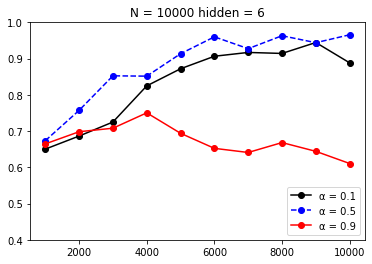

In [ ]:
# ploting data
if do_calc_over:
  plt.ylim(min,1)
  greek_letterz=[chr(code) for code in range(945,970)]
  plt.plot(x,y[0], marker='o', label = greek_letterz[0] + ' = 0.1', color=(0,0,0 ))
  plt.plot(x,y[1], marker='o', label = greek_letterz[0] + ' = 0.5', color=(0,0,1 ), linestyle='--')
  plt.plot(x,y[2], marker='o', label = greek_letterz[0] + ' = 0.9', color=(1,0,0 ))
  plt.legend(loc='lower right')
  plt.title('N = ' + str(n_data_set )  + ' hidden = ' + str(n_hidden) )#+ ' Max =' + str('{:.4f}'.format(max)) )

  plt.show()  

if do_est_over:   
  plt.ylim(minc,1)
  greek_letterz=[chr(code) for code in range(945,970)]
  plt.plot(x,y2[0], marker='o', label = greek_letterz[0] + ' = 0.1', color=(0,0,0 ))
  plt.plot(x,y2[1], marker='o', label = greek_letterz[0] + ' = 0.5', color=(0,0,1 ), linestyle='--')
  plt.plot(x,y2[2], marker='o', label = greek_letterz[0] + ' = 0.9', color=(1,0,0 ))
  plt.legend(loc='lower right')
  plt.title('Estimated overlap. N = ' + str(n_data_set )  + ' hidden = ' + str(n_hidden) )#+ ' Max =' + str('{:.4f}'.format(max)) )

  plt.show()

In [ ]:
y[1]


#W20 estimation

In [ ]:
  n_visual = 20
  n_hidden = 20
  alpha = 0.5
  n_epochs = 5
  n_data_set = 5000
  n_gibb = 100
  n_trip = 10
  x = []
  y = []
  min = 1
  
  test = TestWn( n_visuallayer = n_visual, n_hiddenlayer = n_hidden, alpha = alpha, n_epochs = n_epochs , n_data_source = n_data_set )
  all_data = test.train()
  ovl = Overlap_Wn( nv = n_visual, nh = n_hidden) 
  for data in all_data:
    step = data[1]
    overc = ovl.est_overlap( b = data[2], c = data[3], w = data[4], n = n_gibb, t = n_trip)
    y.append(overc)
    x.append(step)
    if min > overc:
      min = overc
    
  if min > 0.4:
    min = 0.4

training rbm with epochs =  5
   >> training >> epoch = 1
   >> training >> epoch = 2
   >> training >> epoch = 3
   >> training >> epoch = 4
   >> training >> epoch = 5
rbm trained 
 > Estimate Overlap > Prob. Distribution Sigmas OK ...
 > Estimate Overlap > Prob. Distribution Sigmas Intersection ...
 > Estimate Overlap > n 100 N 20 sigmas_intersection 54
 > Estimate Overlap > Prob. Distribution sum3 ...
 > Estimate Overlap > Done ________
 > Estimate Overlap > Prob. Distribution Sigmas OK ...
 > Estimate Overlap > Prob. Distribution Sigmas Intersection ...
 > Estimate Overlap > n 100 N 20 sigmas_intersection 57
 > Estimate Overlap > Prob. Distribution sum3 ...
 > Estimate Overlap > Done ________
 > Estimate Overlap > Prob. Distribution Sigmas OK ...
 > Estimate Overlap > Prob. Distribution Sigmas Intersection ...
 > Estimate Overlap > n 100 N 20 sigmas_intersection 70
 > Estimate Overlap > Prob. Distribution sum3 ...
 > Estimate Overlap > Done ________
 > Estimate Overlap > Prob. Dis

[0.5107697759211393, 0.5094200234368601, 0.603763411034475, 0.7075282409675606, 0.8311135145339528]


Text(0.5, 1.0, 'Estimation. N = 5000 hidden = 20 alpha = 0.5 Epochs = 5')

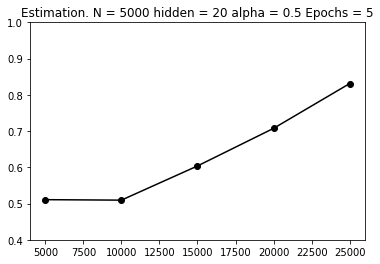

In [ ]:
  print(y)
  plt.ylim(min,1)
  plt.plot(x,y, marker='o', color=(0,0,0 ))
 
  plt.title('Estimation. N = ' + str(n_data_set )  + ' hidden = ' + str(n_hidden) + ' alpha = ' + str(alpha) + ' Epochs = ' + str(n_epochs))

#Plot Distribution

In [ ]:
class Plot:
  def __init__(self, sigmas, title = 'plot'):
    self.__sigmas = sigmas
    self.__title = title
  def show(self):
    length = len(self.__sigmas)
    unique, rev = np.unique(self.__sigmas, return_inverse=True)
    np.bincount(rev)
    X = np.column_stack((unique,np.bincount(rev)/length))
    plt.title(self.__title)
    plt.bar(x=X[:, 0], height=X[:, 1])
    plt.xticks(unique)
    plt.yticks(np.arange(0, 0.2, step=0.02))
    plt.show()     
  def title(self, title = 'plot'):
    self.__title = title


In [86]:
n_visual = 20
n_hidden = 20
alpha = 0.5
n_epochs = 1
n_data_set = 1000
n_gibb = 1000
n_trip = 1


training rbm with epochs =  1
   >> training >> epoch = 1
rbm trained 


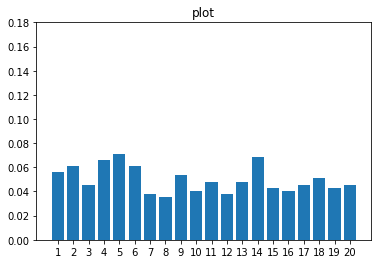

In [87]:
test = TestWn( n_visuallayer= n_visual, n_hiddenlayer= n_hidden, alpha = alpha, n_epochs = n_epochs , n_data_source = n_data_set)
epochs = test.train()
plot = Plot( test.good_gibb(n_gibb,n_trip) )
plot.show()